In [1]:
import sionna.rt
import xarray as xr
import time
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies
print("Sionna version:", sionna.rt.__version__)
print("tf version:", tf.__version__)


2025-10-14 07:48:59.112351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760428139.166630  394829 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760428139.183599  394829 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760428139.225570  394829 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760428139.225596  394829 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760428139.225601  394829 computation_placer.cc:177] computation placer alr

Sionna version: 1.0.2
tf version: 2.19.0


In [2]:
# select GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("GPU:", gpus)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU') # only use the first GPU
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    print("Using GPU:", gpus[0].name)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

else:
  print("No GPU found, using CPU.")



GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU
Using GPU: /physical_device:GPU:0


I0000 00:00:1760428151.105942  394829 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13741 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:01:00.0, compute capability: 7.5


## Loading the scene

In [3]:
# Load scene
scene = load_scene(r"/home/user/6GTandem_RT_server/6G_Tandem_kantoorruimte_v10/office_space.xml") 

2025-10-14 07:49:14 WARN wrk0 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

In [4]:
# open interactive window to preview the scene (this takes a while)
scene.preview();


In [5]:
# load the config file
def load_config(path='/home/user/6GTandem_RT_server/src_ant_pat_plus_movement/config.yaml'):
    with open(path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# load config file
config = load_config()



## Changing the radio matrials 
The default radio materials in Sionna follow the ITU models. Hence the frequency dependency of the relative permittivity and the conductivity is modeled as
$$\varepsilon_r = a f_{GHz}^b$$
$$\sigma = cf_{GHz}^d.$$
$a,b,c$ and $d$ are constants that characterize the material. Note that $b$ is zero for all materials, hence $\varepsilon_r$ is independent of the frequency. The ITU model characterized a number of materials. Unfortunately it is only valid up to 100 GHz. 

An extension of these models is made in Hexa-X (Deliverable D2.3  Radio models and enabling techniques  towards ultra-high data rate links and  capacity in 6G), coined the ITUF models. It maintains the same models for the relative permittivity and conductivity. However, the material dependent constants are fitted on measurments above 100 GHz, up to 300 GHz. An overview of the parameters is given below:

![Image not found](ituf.PNG)

In the following cells we change the ITU model by the updated ITUF models.

In [6]:

# check which materials are available in the scene
for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

no-name-1      ituf_glass
no-name-2      ituf_metal
Ceiling_Detail ituf_polystyrene
no-name-3      ituf_concrete
no-name-4      ituf_mdf


In [8]:
# define callbacks to set conductivity and relative permittivity based on ITUF materials from hexa-x
def ituf_glass_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 6.2
  c, d = 0.005, 1.2
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_concrete_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.9
  c, d = 0.002, 1.3
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_metal_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.0  
  c, d = 10**7, 0.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_polystyrene_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.05 #eta_r
  c, d = 0.000008, 1.1
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_mdf_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 2.0 #eta_r
  c, d = 0.005, 1.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

# add callbacks to the materials

# polystyrene
ceiling_object = scene.get("Ceiling_Detail")
ceiling_object.radio_material.frequency_update_callback = ituf_polystyrene_callback
print(ceiling_object.radio_material.name)
print(ceiling_object.radio_material.frequency_update_callback)

# no-name-1 => ituf_glass
glass_objects = scene.get("no-name-1")
glass_objects.radio_material.frequency_update_callback = ituf_glass_callback
print(glass_objects.radio_material.name)
print(glass_objects.radio_material.frequency_update_callback)

# no-name-2 => ituf_concrete
concrete_objects = scene.get("no-name-2")
concrete_objects.radio_material.frequency_update_callback = ituf_concrete_callback
print(concrete_objects.radio_material.name)
print(concrete_objects.radio_material.frequency_update_callback)

# no-name-3 => ituf_metal
metal_objects = scene.get("no-name-3")
metal_objects.radio_material.frequency_update_callback = ituf_metal_callback
print(metal_objects.radio_material.name)
print(metal_objects.radio_material.frequency_update_callback)

# no-name-4 => ituf_mdf
metal_mdf = scene.get("no-name-4")
metal_mdf.radio_material.frequency_update_callback = ituf_mdf_callback
print(metal_mdf.radio_material.name)
print(metal_mdf.radio_material.frequency_update_callback)


ituf_polystyrene
<function ituf_polystyrene_callback at 0x7443bbbc0180>
ituf_glass
<function ituf_glass_callback at 0x7445c419ba60>
ituf_metal
<function ituf_concrete_callback at 0x7443bbbc0040>
ituf_concrete
<function ituf_metal_callback at 0x7443bbbc00e0>
ituf_mdf
<function ituf_mdf_callback at 0x7443bbbc0220>


In [9]:
""" sanity check """
# check conductivity and relative permittivity at different frequencies
sub_GHz = 3.5e9
sub_THz = 170e9
for key, value in scene.objects.items(): # loop through material names and print them
    print(f'---------------{key=}----------------')
    # Print name of assigned radio material for different frequenies
    for f in [sub_GHz, sub_THz]: # Print for differrent frequencies
        scene.frequency = f
        value.radio_material.frequency_update() # update the frequency of the objects
        print(f"\nRadioMaterial: {value.radio_material.name} @ {scene.frequency/1e9}GHz")
        print("Conductivity:", value.radio_material.conductivity.numpy())
        print("Relative permittivity:", value.radio_material.relative_permittivity.numpy())
        print("Scattering coefficient:", value.radio_material.scattering_coefficient.numpy())
        print("XPD coefficient:", value.radio_material.xpd_coefficient.numpy())




---------------key='no-name-1'----------------

RadioMaterial: ituf_glass @ [3.5]GHz
Conductivity: [0.02248287]
Relative permittivity: [6.2]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_glass @ [170]GHz
Conductivity: [2.3741536]
Relative permittivity: [6.2]
Scattering coefficient: [0.]
XPD coefficient: [0.]
---------------key='no-name-2'----------------

RadioMaterial: ituf_metal @ [3.5]GHz
Conductivity: [0.01019339]
Relative permittivity: [1.9]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_metal @ [170]GHz
Conductivity: [1.5871336]
Relative permittivity: [1.9]
Scattering coefficient: [0.]
XPD coefficient: [0.]
---------------key='Ceiling_Detail'----------------

RadioMaterial: ituf_polystyrene @ [3.5]GHz
Conductivity: [3.1736927e-05]
Relative permittivity: [1.05]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_polystyrene @ [170]GHz
Conductivity: [0.00227292]
Relative permittivity: [1.05]
Scattering coefficie

## Configure the Tx and Rx


In [10]:
# load config file
N_antennas = config['antenna_config']['N_antennas_per_axis']
scene.tx_array = PlanarArray(num_rows=N_antennas,
                                num_cols=N_antennas,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern=config['antenna_config']['pattern'],
                                polarization=config['antenna_config']['polarization'])

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=N_antennas,
                            num_cols=N_antennas,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern=config['antenna_config']['pattern'],
                            polarization=config['antenna_config']['polarization'])

## load the stripe configurations & instantiate the path solver

In [11]:
# sub-THz stripe specs 
stripe_start_pos = config['stripe_config']['stripe_start_pos']
N_RUs = config['stripe_config']['N_RUs'] # adjust to size of the room (along y axis)
N_stripes = config['stripe_config']['N_stripes']# adjust to size of the room (alang x axis)
total_N_RUs = N_RUs * N_stripes # total number of radio units
space_between_RUs = config['stripe_config']['space_between_RUs'] # in meters
space_between_stripses = config['stripe_config']['space_between_stripes'] # in meters

# OFDM system parameters
BW = config['subTHz_config']['bw'] # Bandwidth of the system
num_subcarriers = config['subTHz_config']['num_subcarriers']
subcarrier_spacing = BW / num_subcarriers
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing) # Compute baseband frequencies of subcarriers relative to the carrier frequency

# set scene frequency
scene.frequency = config['subTHz_config']['fc']# Set frequency to fc 

# Instantiate a path solver
p_solver  = PathSolver()


## Add the user to the scene

In [12]:
# add the ue to the scene
x, y, z = 7, 12, 1
ue_pos = [float(x), float(y), float(z)]

# Create a receiver
rx = Receiver(name=f"rx_ue",
            position=ue_pos,
            display_radius=0.5)

# Point the receiver upwards
rx.look_at([ue_pos[0], ue_pos[1], 3.5]) # Receiver points upwards

# Add receiver instance to scene
scene.add(rx)



## Add the stripes to the scene & visualize

In [13]:
# loop over all stripes
for stripe_idx in range(N_stripes):
    # loop over all RUs 
    for RU_idx in range(N_RUs):
        # compute RU position
        tx_pos = [stripe_start_pos[0] + stripe_idx * space_between_stripses,
                stripe_start_pos[1] + RU_idx * space_between_RUs,
                stripe_start_pos[2]]
        print(f"Adding stripe {stripe_idx}, RU {RU_idx} at position {tx_pos}")
        
        # Create RU transmitter instance
        tx = Transmitter(name=f"tx_stripe_{stripe_idx}_RU_{RU_idx}",
                    position=tx_pos,
                    display_radius=0.1)

        # Add RU transmitter instance to scene
        scene.add(tx)

        # Point the transmitter downwards
        tx.look_at([tx_pos[0], tx_pos[1], 0]) # Transmitter points downwards

Adding stripe 0, RU 0 at position [2, 2.5, 3.5]
Adding stripe 0, RU 1 at position [2, 3.5, 3.5]
Adding stripe 0, RU 2 at position [2, 4.5, 3.5]
Adding stripe 0, RU 3 at position [2, 5.5, 3.5]
Adding stripe 0, RU 4 at position [2, 6.5, 3.5]
Adding stripe 0, RU 5 at position [2, 7.5, 3.5]
Adding stripe 0, RU 6 at position [2, 8.5, 3.5]
Adding stripe 0, RU 7 at position [2, 9.5, 3.5]
Adding stripe 0, RU 8 at position [2, 10.5, 3.5]
Adding stripe 0, RU 9 at position [2, 11.5, 3.5]
Adding stripe 0, RU 10 at position [2, 12.5, 3.5]
Adding stripe 0, RU 11 at position [2, 13.5, 3.5]
Adding stripe 0, RU 12 at position [2, 14.5, 3.5]
Adding stripe 0, RU 13 at position [2, 15.5, 3.5]
Adding stripe 0, RU 14 at position [2, 16.5, 3.5]
Adding stripe 0, RU 15 at position [2, 17.5, 3.5]
Adding stripe 0, RU 16 at position [2, 18.5, 3.5]
Adding stripe 0, RU 17 at position [2, 19.5, 3.5]
Adding stripe 0, RU 18 at position [2, 20.5, 3.5]
Adding stripe 0, RU 19 at position [2, 21.5, 3.5]
Adding stripe 1, R

In [14]:
scene.preview();

In [15]:
# remove all the transmitters
# loop over all stripes
for stripe_idx in range(N_stripes):
    # loop over all RUs 
    for RU_idx in range(N_RUs):
        # remove tx from the scene after computation
        scene.remove(f"tx_stripe_{stripe_idx}_RU_{RU_idx}")

In [16]:
scene.preview();

## Perform ray tracing
In the previous cells we added all the Radio Units however due to the large number of radio units, we cannot perform raytracing of all of them in one go. As such, we removed all RUs & will do the ray tracing for a single RU here as an example

Shape of h_freq:  (1, 4, 1, 4, 1, 1024)
Shape of h_freq reshaped:  (4, 4, 1024)


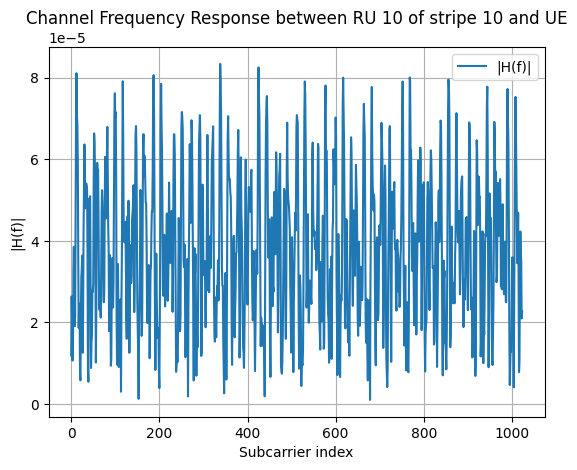

In [17]:
# select the RU
RU_idx = 10
stripe_idx = 10

# compute RU position
tx_pos = [stripe_start_pos[0] + stripe_idx * space_between_stripses,
        stripe_start_pos[1] + RU_idx * space_between_RUs,
        stripe_start_pos[2]]

# Create RU transmitter instance
tx = Transmitter(name=f"tx_stripe_{stripe_idx}_RU_{RU_idx}",
            position=tx_pos,
            display_radius=0.5)

# Add RU transmitter instance to scene
scene.add(tx)

# Point the transmitter downwards
tx.look_at([tx_pos[0], tx_pos[1], 0]) # Transmitter points downwards

# compute the paths
paths = p_solver(scene=scene,
                max_depth=5,
                los=True,
                specular_reflection=True,
                diffuse_reflection=False, # no scattering
                refraction=True,
                synthetic_array=False,
                seed=41)

# Compute channel frequency response
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
h_freq = paths.cfr(frequencies=frequencies,
                    normalize_delays=True,
                    out_type="numpy")
print("Shape of h_freq: ", h_freq.shape)

# reshape to [nr_rx_antennas, nr_tx_antennas, nr_subcarriers]
h_freq = np.squeeze(h_freq)
print("Shape of h_freq reshaped: ", h_freq.shape)

# plot
plt.plot(np.abs(h_freq[0,0,:]), label='|H(f)|')
plt.xlabel('Subcarrier index')
plt.ylabel('|H(f)|')
plt.title(f'Channel Frequency Response between RU {RU_idx} of stripe {stripe_idx} and UE')
plt.grid()
plt.legend()           
plt.show()



Using 4096 subcarriers with spacing 3.0517578125 MHz over a bandwidth of 12.5 GHz
stripes: 7, RUs/stripe: 20, antennas: 4, subcarriers: 4096
expected datasize for 1 ue loc: 70.0 MB
expected datasize for 4000 ue loc: 273.4375 GB


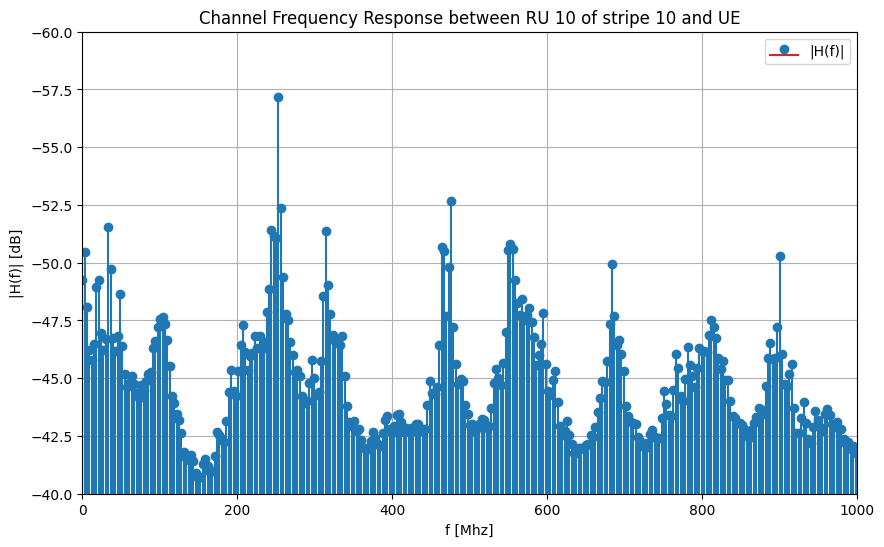

In [93]:
""" check different subcarrier spacings"""

# OFDM system parameters
BW = config['subTHz_config']['bw'] # Bandwidth of the system
num_subcarriers = 2**12#config['subTHz_config']['num_subcarriers']
subcarrier_spacing = BW / num_subcarriers
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing) # Compute baseband frequencies of subcarriers relative to the carrier frequency
print(f"Using {num_subcarriers} subcarriers with spacing {subcarrier_spacing/1e6} MHz over a bandwidth of {BW/1e9} GHz")

n_stripes = 7
n_rusperstripe = 20
nr_ant = 4
n_uelocs = 4000
print(f'stripes: {n_stripes}, RUs/stripe: {n_rusperstripe}, antennas: {nr_ant}, subcarriers: {num_subcarriers}')
print(f'expected datasize for 1 ue loc: {n_stripes*n_rusperstripe*nr_ant*nr_ant*num_subcarriers*8/(1024**2)} MB')
print(f'expected datasize for {n_uelocs} ue loc: {n_uelocs*n_stripes*n_rusperstripe*nr_ant*nr_ant*num_subcarriers*8/(1024**3)} GB')


# Compute channel frequency response
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
h_freq = paths.cfr(frequencies=frequencies,
                    normalize_delays=True,
                    out_type="numpy")
#print("Shape of h_freq: ", h_freq.shape)

# reshape to [nr_rx_antennas, nr_tx_antennas, nr_subcarriers]
h_freq = np.squeeze(h_freq)
#print("Shape of h_freq reshaped: ", h_freq.shape)

# plot
plt.figure(figsize=(10,6))
faxis= np.arange(num_subcarriers) * subcarrier_spacing / 1e6 # in MHz
plt.stem(faxis, 10*np.log10(np.abs(h_freq[0,0,:])), label='|H(f)|')
plt.xlabel('f [Mhz]')
plt.ylabel('|H(f)| [dB]')
plt.xlim([0, 1000])
plt.ylim([-60, -40])
plt.title(f'Channel Frequency Response between RU {RU_idx} of stripe {stripe_idx} and UE')
plt.grid()
plt.gca().invert_yaxis()   
plt.legend()           
plt.show()

a shape: (1, 4, 1, 4, 53, 1), tau shape: (1, 4, 1, 4, 53)
power: [[[-163.56035  -160.09338  -160.07912  -131.49478  -168.10172
   -135.77745  -128.86981  -127.11213  -127.86335  -125.34538
   -141.78561  -144.72043  -158.10492  -153.20021  -127.20865
   -115.4042   -165.2775   -125.11016  -121.92455  -120.60333
   -159.33875  -130.19443  -127.06603  -129.93326  -110.41243
   -132.20338  -108.02334  -116.58184  -118.07439  -126.360504
   -110.06397  -144.15152  -126.71409  -130.96613  -114.3354
   -114.48266  -124.59456  -127.7657   -128.35315  -131.66444
    -91.391594  -94.95297  -156.1943    -97.01973  -145.1109
          -inf        -inf        -inf        -inf        -inf
          -inf        -inf        -inf]
  [-151.83997  -127.863235 -141.78549  -144.72032  -158.10478
   -153.20273  -155.2694   -127.20611  -163.56506  -110.41302
   -132.20432  -108.023315 -116.5798   -118.07042  -126.35825
   -110.078156 -115.40515  -125.14637  -158.38432  -160.66942
   -148.48285  -156.37808  

/tmp/ipykernel_345441/29761107.py:44: RuntimeWarning: divide by zero encountered in log10
  print(f'power: {10*np.log10(power)}')
/tmp/ipykernel_345441/29761107.py:47: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(path_length_cm[0, 0, :], 10*np.log10(power[0, 0, :]))


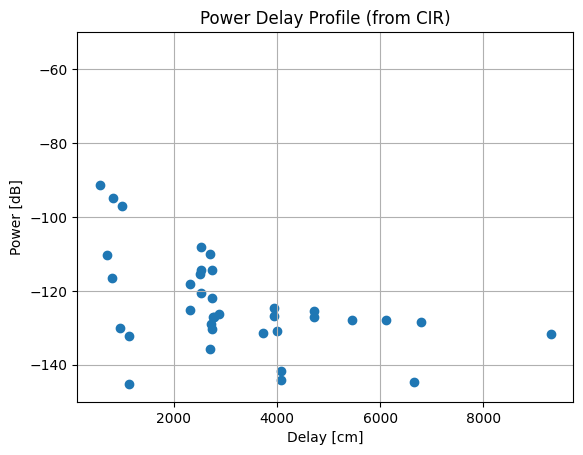

In [17]:
a, tau = paths.cir(normalize_delays=False, out_type="numpy")
print(f'a shape: {a.shape}, tau shape: {tau.shape}')

t = np.squeeze(tau)/1e-9 # Scale to ns
a_abs = np.abs(np.squeeze(a))
a_max = np.max(a_abs)

# # And plot the CIR
# plt.figure()
# plt.title("Channel impulse response")
# plt.stem(t, a_abs)
# plt.xlabel(r"$\tau$ [ns]")
# plt.ylabel(r"$|a|$");


power = np.abs(np.squeeze(a))**2   # path power
# # Sort by delay
# sort_idx = np.argsort(t)
# t_sorted = t[sort_idx]
# power_sorted = power[sort_idx]
# print(t_sorted)
# print(power_sorted)
# plt.figure()
# plt.plot(t_sorted, 10*np.log10(power_sorted))
# plt.xlabel("Delay [ns]")
# plt.ylabel("Power [dB]")
# plt.title("Power Delay Profile (from CIR)")
# plt.grid(True)
# plt.show()


# plt.figure()
# plt.stem(t, 10*np.log10(power))
# plt.xlabel("Delay [ns]")
# plt.ylabel("Power [dB]")
# plt.title("Power Delay Profile (from CIR)")
# plt.grid(True)
# plt.show()


c = 3e8  # speed of light [m/s]
tau_s = np.squeeze(tau)  
path_length_cm = tau_s * c * 100  
print(f'power: {10*np.log10(power)}')
print(f'pwr shape: {power.shape}, path_length_cm shape: {path_length_cm.shape}')
plt.figure()
plt.scatter(path_length_cm[0, 0, :], 10*np.log10(power[0, 0, :]))
plt.ylim([-50, -150])
plt.xlabel("Delay [cm]")
plt.ylabel("Power [dB]")
plt.title("Power Delay Profile (from CIR)")
plt.grid(True)
plt.gca().invert_yaxis()  # now -150 dB is at the bottom, -60 dB at top
plt.show()

In [18]:
# preview with the paths
scene.preview(paths=paths)

# remove tx from the scene after computation
scene.remove(f"tx_stripe_{stripe_idx}_RU_{RU_idx}")